In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


2025-07-12 14:20:41.083510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752330041.430566      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752330041.530715      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#  Load dataset
train_data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
print(f"Train shape: {train_data.shape}, Test shape: {test_data.shape}")

#  Prepare features and labels
X_train_full = train_data.drop("label", axis=1)
y_train_full = train_data["label"]

#  Normalize and reshape images
X_train = X_train_full / 255.0
X_test = test_data / 255.0
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)
y_train = y_train_full.astype("int")

#  Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


Train shape: (42000, 785), Test shape: (28000, 784)


In [3]:
#  Define Swish activation
def swish(x):
    return x * K.sigmoid(x)

#  Define Squeeze-and-Excitation block
def se_block(input_tensor, reduction=16):
    channels = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(channels // reduction, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, channels))(se)
    return layers.Multiply()([input_tensor, se])

#  Define the CNN model architecture
def build_model():
    inputs = layers.Input(shape=(28, 28, 1))

    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(swish)(x)
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(swish)(x)
    x = se_block(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(swish)(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(swish)(x)
    x = se_block(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(swish)(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [4]:
# Image data augmentation
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)


📂 Fold 1


I0000 00:00:1752330205.725988      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752330205.726713      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1752330214.611994     104 service.cc:148] XLA service 0x79d888009c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752330214.613650     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752330214.613682     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752330215.420817     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


 10/525 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.2444 - loss: 2.2290  

I0000 00:00:1752330222.485846     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


525/525 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.7964 - loss: 0.6475 - val_accuracy: 0.9832 - val_loss: 0.0677
Epoch 2/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9626 - loss: 0.1294 - val_accuracy: 0.9836 - val_loss: 0.0529
Epoch 3/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9757 - loss: 0.0837 - val_accuracy: 0.9902 - val_loss: 0.0318
Epoch 4/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9765 - loss: 0.0766 - val_accuracy: 0.9882 - val_loss: 0.0448
Epoch 5/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9790 - loss: 0.0685 - val_accuracy: 0.9920 - val_loss: 0.0312
Epoch 6/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9817 - loss: 0.0600 - val_accuracy: 0.9929 - val_loss: 0.0287
Epoch 7/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9819 - loss: 0.0569 - val_accuracy: 0.9929 - val_loss: 0.0279
Epoch 8/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9835 - loss: 0.0513 - val_accurac

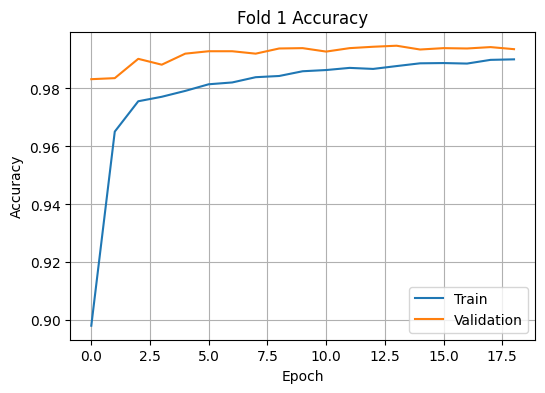


📂 Fold 2
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.7962 - loss: 0.6468 - val_accuracy: 0.9826 - val_loss: 0.0755
Epoch 2/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9639 - loss: 0.1230 - val_accuracy: 0.9895 - val_loss: 0.0329
Epoch 3/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9722 - loss: 0.0906 - val_accuracy: 0.9876 - val_loss: 0.0381
Epoch 4/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9783 - loss: 0.0719 - val_accuracy: 0.9892 - val_loss: 0.0369
Epoch 5/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9819 - loss: 0.0612 - val_accuracy: 0.9899 - val_loss: 0.0288
Epoch 6/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9814 - loss: 0.0618 - val_accuracy: 0.9915 - val_loss: 0.0289
Epoch 7/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9821 - loss: 0.0568 - val_accuracy: 0.9873 - val_loss: 0.0432
Epoch 8/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9830 - loss: 0.0551 - val_accurac

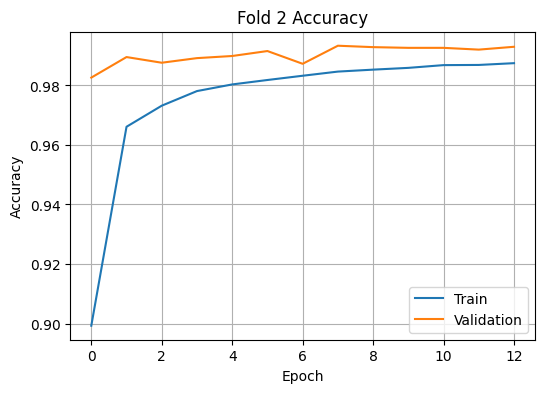


📂 Fold 3
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.7928 - loss: 0.6629 - val_accuracy: 0.9820 - val_loss: 0.0766
Epoch 2/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9616 - loss: 0.1293 - val_accuracy: 0.9843 - val_loss: 0.0503
Epoch 3/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9743 - loss: 0.0870 - val_accuracy: 0.9900 - val_loss: 0.0338
Epoch 4/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9769 - loss: 0.0746 - val_accuracy: 0.9899 - val_loss: 0.0344
Epoch 5/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9787 - loss: 0.0668 - val_accuracy: 0.9892 - val_loss: 0.0299
Epoch 6/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9822 - loss: 0.0586 - val_accuracy: 0.9904 - val_loss: 0.0303
Epoch 7/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9845 - loss: 0.0509 - val_accuracy: 0.9918 - val_loss: 0.0255
Epoch 8/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9839 - loss: 0.0483 - val_accurac

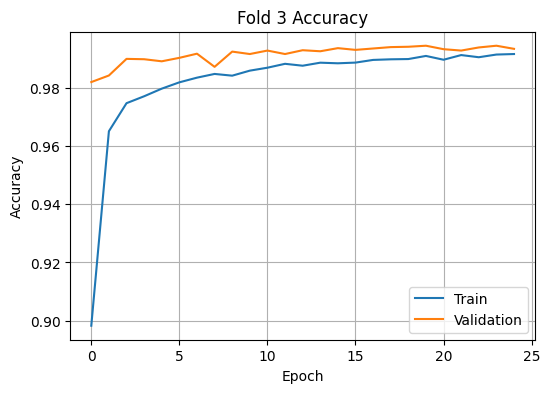


📂 Fold 4
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.7938 - loss: 0.6621 - val_accuracy: 0.9632 - val_loss: 0.1266
Epoch 2/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9624 - loss: 0.1301 - val_accuracy: 0.9873 - val_loss: 0.0454
Epoch 3/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9729 - loss: 0.0963 - val_accuracy: 0.9892 - val_loss: 0.0375
Epoch 4/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9766 - loss: 0.0740 - val_accuracy: 0.9882 - val_loss: 0.0406
Epoch 5/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9778 - loss: 0.0731 - val_accuracy: 0.9898 - val_loss: 0.0316
Epoch 6/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9821 - loss: 0.0605 - val_accuracy: 0.9929 - val_loss: 0.0267
Epoch 7/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9819 - loss: 0.0579 - val_accuracy: 0.9931 - val_loss: 0.0222
Epoch 8/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9826 - loss: 0.0548 - val_accurac

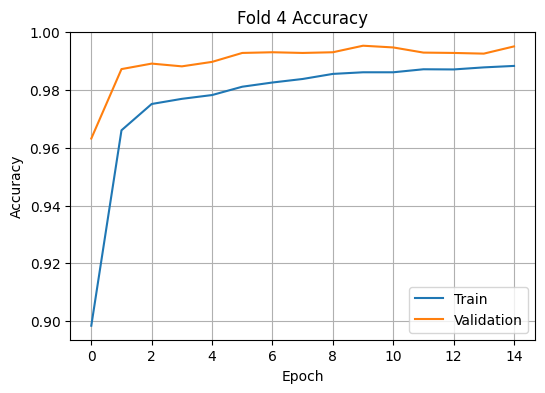


📂 Fold 5
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.7946 - loss: 0.6487 - val_accuracy: 0.9812 - val_loss: 0.0724
Epoch 2/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9621 - loss: 0.1296 - val_accuracy: 0.9887 - val_loss: 0.0353
Epoch 3/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9689 - loss: 0.0987 - val_accuracy: 0.9905 - val_loss: 0.0303
Epoch 4/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9774 - loss: 0.0757 - val_accuracy: 0.9906 - val_loss: 0.0296
Epoch 5/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9796 - loss: 0.0687 - val_accuracy: 0.9899 - val_loss: 0.0313
Epoch 6/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9808 - loss: 0.0626 - val_accuracy: 0.9885 - val_loss: 0.0376
Epoch 7/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9815 - loss: 0.0584 - val_accuracy: 0.9912 - val_loss: 0.0295
Epoch 8/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9833 - loss: 0.0546 - val_accurac

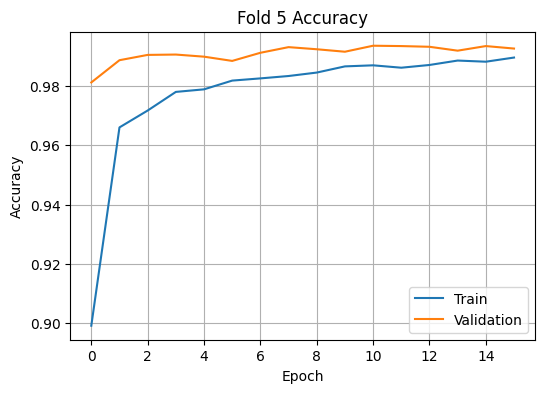


📊 Mean Accuracy: 0.9943


In [5]:
# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
models_list = []
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"\n📂 Fold {fold + 1}")
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    model = build_model()
    aug.fit(X_tr)

    early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    history = model.fit(
        aug.flow(X_tr, y_tr, batch_size=64),
        validation_data=(X_val, y_val),
        epochs=30,
        callbacks=[early_stop],
        verbose=1
    )

    #  Evaluate and store model
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    fold_accuracies.append(val_acc)
    models_list.append(model)
    print(f"Fold {fold + 1} Accuracy: {val_acc:.4f}")

    #  Plot training and validation accuracy per fold
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'Fold {fold + 1} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

#  Average accuracy from all folds
mean_acc = np.mean(fold_accuracies)
print(f"\n📊 Mean Accuracy: {mean_acc:.4f}")

In [6]:
# Ensemble prediction on test set
print("\n📊 Predicting using ensemble of models...")
all_preds = np.zeros((X_test.shape[0], 10))

for model in models_list:
    all_preds += model.predict(X_test, verbose=0)

ensemble_preds = np.argmax(all_preds / len(models_list), axis=1)



📊 Predicting using ensemble of models...


In [7]:
# Create submission file
submission = pd.DataFrame({
    "ImageId": np.arange(1, len(ensemble_preds) + 1),
    "Label": ensemble_preds
})
submission.to_csv("submission.csv", index=False)
print("📁 Submission saved as 'submission.csv'")

📁 Submission saved as 'submission.csv'


<Figure size 800x600 with 0 Axes>

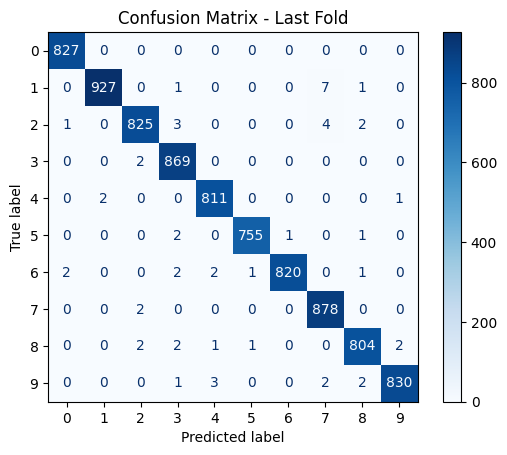

In [8]:
# Confusion Matrix using last fold validation set
last_model = models_list[-1]
y_val_preds = np.argmax(last_model.predict(X_val, verbose=0), axis=1)
cm = confusion_matrix(y_val, y_val_preds)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=np.arange(10)).plot(cmap="Blues")
plt.title("Confusion Matrix - Last Fold")
plt.grid(False)
plt.show()